### Importing the required libraries

In [1]:
import io
import os
import torch
import gc
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

### Loading the dataset

In [2]:
dataset = load_dataset('glue', 'mnli')
dataset

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [3]:
set_seed(123)
epochs = 3

batch_size = 16
max_length = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'gpt2'

In [4]:
class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer,  max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

    def __call__(self, sequences):
        premises = [sequence['premise'] for sequence in sequences]
        hypothesis = [sequence['hypothesis'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        inputs = self.use_tokenizer(text=premises, text_pair = hypothesis, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len, return_token_type_ids=True)
        inputs.update({'labels':torch.tensor(labels)})
        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
    global model
    predictions_labels = []
    true_labels = []
    total_loss = 0

    model.train()

    # For each batch of training data...
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()

        batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

        model.zero_grad()
        outputs = model(**batch)

        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer_.step()
        scheduler_.step()

        predictions_labels.extend(torch.argmax(logits, dim = 1).tolist())

    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss


def validation(dataloader, device_):
    global model
    predictions_labels = []
    true_labels = []
    total_loss = 0

    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

        with torch.no_grad():        
            outputs = model(**batch)

            loss, logits = outputs[:2] 
            #logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
            predict_content = torch.argmax(logits, dim = 1).tolist()
            predictions_labels.extend(predict_content)

    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss

### Loading the model

In [5]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=3)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "right"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


### Creating train, validation and test dataloader

In [6]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,  
                                                          max_sequence_len=max_length)

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

validm_dataloader = DataLoader(dataset['validation_matched'], batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `valm_dataloader` with %d batches!'%len(validm_dataloader))

validmm_dataloader = DataLoader(dataset['validation_mismatched'], batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `valmm_dataloader` with %d batches!'%len(validmm_dataloader))

testm_dataloader = DataLoader(dataset['test_matched'], batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `testm_dataloader` with %d batches!'%len(testm_dataloader))

testmm_dataloader = DataLoader(dataset['test_mismatched'], batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `testmm_dataloader` with %d batches!'%len(testmm_dataloader))

Created `train_dataloader` with 24544 batches!

Created `valm_dataloader` with 614 batches!
Created `valmm_dataloader` with 615 batches!
Created `testm_dataloader` with 613 batches!
Created `testmm_dataloader` with 616 batches!


### Fine-tuning GPT-2

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)


total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
best_valid_acc = 0
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set.
    train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    # Get prediction form model on validation data. 
    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation(validm_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    # Print loss and accuracy values to see how training evolves.
    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    # Store the loss value for plotting the learning curve.
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)
    
    # Check if the current model is the best so far
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        model.save_pretrained("gpt2-mnli")
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
fineTunedModel = GPT2ForSequenceClassification.from_pretrained('gpt2-mnli')
fineTunedModel.cuda()

### Obtaining hidden states averaged over all tokens to get a single dimension of 768 for each example

In [9]:
def getHiddenStates(currModel, dataloader):
    currModel.eval()
    totalHiddenStates = [0]*13
    flag = True
    
    # Evaluate data for one epoch
    for batch in tqdm(dataloader, total=len(dataloader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        
        with torch.no_grad():       
            outputs = currModel(input_ids=input_ids, 
                                     attention_mask=attention_mask, 
                                     token_type_ids = token_type_ids,
                                     output_hidden_states=True, 
                                     return_dict=True)
            hidden_states = outputs.hidden_states
            if flag == True:
                for i in range(len(hidden_states)):
                    totalHiddenStates[i] = hidden_states[i].to("cpu").mean(dim = 1)
                flag = False
            else:
                for i in range(len(hidden_states)):
                    temp = hidden_states[i].to("cpu").mean(dim = 1)
                    totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
    return totalHiddenStates     

In [11]:
hiddenStates = getHiddenStates(model, testm_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_MNLI-m.pt')
print(preTrainedHiddenStates.shape)

hiddenStates = getHiddenStates( fineTunedModel, testm_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_MNLI-m.pt')
print(fineTunedHiddenStates.shape)

  0%|          | 0/613 [00:00<?, ?it/s]

torch.Size([13, 9796, 768])


  0%|          | 0/613 [00:00<?, ?it/s]

torch.Size([13, 9796, 768])


In [29]:
hiddenStates = getHiddenStates(model, testmm_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_MNLI-mm.pt')
print(preTrainedHiddenStates.shape)

hiddenStates = getHiddenStates( fineTunedModel, testmm_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_MNLI-mm.pt')
print(fineTunedHiddenStates.shape)

  0%|          | 0/616 [00:00<?, ?it/s]

torch.Size([13, 9847, 768])


  0%|          | 0/616 [00:00<?, ?it/s]

torch.Size([13, 9847, 768])


In [48]:
hiddenStates = getHiddenStates(model, testax_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_AX.pt')
print(preTrainedHiddenStates.shape)

hiddenStates = getHiddenStates( fineTunedModel, testax_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_AX.pt')
print(fineTunedHiddenStates.shape)

  0%|          | 0/69 [00:00<?, ?it/s]

torch.Size([13, 1104, 768])


  0%|          | 0/69 [00:00<?, ?it/s]

torch.Size([13, 1104, 768])


In [49]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [50]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates[i].to(device)
        Y = fineTunedHiddenStates[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

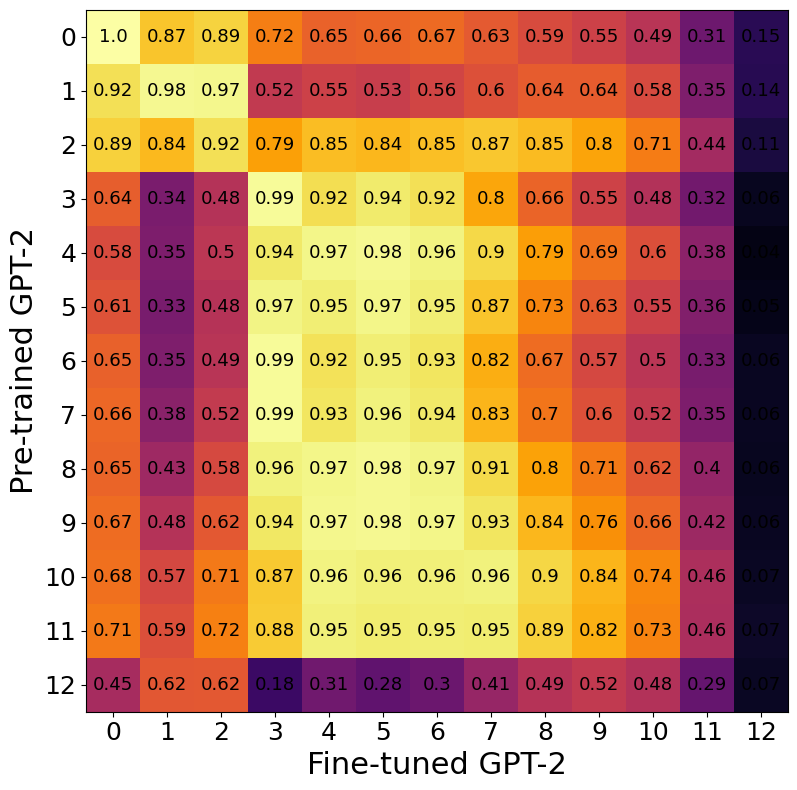

In [51]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 18)
plt.yticks(np.arange(0,13), fontsize = 18)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(cka_matrix[x][y], xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained GPT-2', fontsize = 22)
plt.xlabel('Fine-tuned GPT-2', fontsize = 22)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('AX_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('AX_preTrained_fineTuned.jpg',  bbox_inches='tight')

### Calculating layerwise STIR

In [52]:
preTrainedHiddenStates = torch.load('./preTrainedHiddenStates_AX.pt').to(device)
fineTunedHiddenStates  = torch.load('./fineTunedHiddenStates_AX.pt').to(device)
print(preTrainedHiddenStates.shape,fineTunedHiddenStates.shape)

torch.Size([13, 1104, 768]) torch.Size([13, 1104, 768])


In [53]:
distinm1 = []
distinm2 = []
for i in range(13):
    distinm1.append(torch.cdist(preTrainedHiddenStates[i], preTrainedHiddenStates[i]))
    distinm2.append(torch.cdist(fineTunedHiddenStates[i], fineTunedHiddenStates[i]))

In [54]:
for i in range(13):
    for j in range(distinm1[0].shape[0]):
        distinm1[i][j][j] = 100000.0
        distinm2[i][j][j] = 100000.0

In [55]:
num_rows = preTrainedHiddenStates.shape[1]
minDistIndForm1 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm1[i][j]))
    minDistIndForm1.append(temp)
    
minDistIndForm2 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm2[i][j]))
    minDistIndForm2.append(temp)

In [56]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [57]:
import random
def calculate(noOfSamples, noOfTimes):
    STIRm2m1 = []
    STIRm1m2 = []
    CKA = []
    for i in range(13):
        stirm2m1 = 0
        stirm1m2 = 0
        cka = 0
        for j in range(noOfTimes):
            num_list = random.sample(range(0, num_rows), noOfSamples)
            X = []
            X_ = []
            Y = []
            Y_ = []
            for k in range(len(num_list)):
                X.append(fineTunedHiddenStates[i][num_list[k]])
                X_.append(fineTunedHiddenStates[i][minDistIndForm1[i][num_list[k]]])
                Y.append(preTrainedHiddenStates[i][num_list[k]])
                Y_.append(preTrainedHiddenStates[i][minDistIndForm2[i][num_list[k]]])
                
            X = torch.stack(X, dim = 0)
            X_ = torch.stack(X_, dim = 0)
            Y = torch.stack(Y, dim = 0)
            Y_ = torch.stack(Y_, dim = 0)
            
            stirm2m1 = stirm2m1 + cuda_cka.linear_CKA(X, X_)
            stirm1m2 = stirm1m2 + cuda_cka.linear_CKA(Y, Y_)
            cka = cka + cuda_cka.linear_CKA(Y, X)
        
        STIRm2m1.append(stirm2m1/noOfTimes)
        STIRm1m2.append(stirm1m2/noOfTimes)
        CKA.append(cka/noOfTimes)
    return STIRm2m1, STIRm1m2, CKA

In [58]:
STIRm2m1, STIRm1m2, CKA = calculate(num_rows//2, 20)

In [59]:
STIRm2m1 = torch.stack(STIRm2m1, dim = 0)
STIRm1m2 = torch.stack(STIRm1m2,dim = 0)
CKA = torch.stack(CKA, dim = 0)

In [60]:
STIRm2m1 = STIRm2m1.to("cpu")
STIRm2m1 = STIRm2m1.numpy()
STIRm1m2 = STIRm1m2.to("cpu")
STIRm1m2 = STIRm1m2.numpy()
CKA = CKA .to("cpu")
CKA = CKA .numpy()

In [24]:
print('MNLI-Matched')
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

MNLI-Matched
STIRm2m1: [0.97793275 0.95967525 0.9426309  0.94598246 0.9302195  0.91607046
 0.8828673  0.87228185 0.82770795 0.73581237 0.44619033 0.17691769
 0.0413119 ]
STIRm1m2: [0.9770285  0.94079334 0.9451944  0.89878744 0.8886737  0.84702015
 0.7697865  0.766539   0.8319899  0.83846474 0.8234152  0.7456189
 0.54106224]
CKA: [0.99993896 0.9796373  0.9470374  0.9224388  0.86543715 0.8349881
 0.8010182  0.79691315 0.81727886 0.79352134 0.6194167  0.35281882
 0.14129819]


In [25]:
import numpy as np
print('STIRm2m1: ', np.round(STIRm2m1, 2))
print('STIRm1m2: ', np.round(STIRm1m2, 2))
print('CKA: ', np.round(CKA, 2))

STIRm2m1:  [0.98 0.96 0.94 0.95 0.93 0.92 0.88 0.87 0.83 0.74 0.45 0.18 0.04]
STIRm1m2:  [0.98 0.94 0.95 0.9  0.89 0.85 0.77 0.77 0.83 0.84 0.82 0.75 0.54]
CKA:  [1.   0.98 0.95 0.92 0.87 0.83 0.8  0.8  0.82 0.79 0.62 0.35 0.14]


In [39]:
print('MNLI-Mismatched')
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

MNLI-Mismatched
STIRm2m1: [0.97826004 0.9602205  0.9424778  0.94458765 0.928836   0.91326
 0.87721187 0.8603622  0.8038123  0.7017151  0.39498535 0.13470973
 0.03182544]
STIRm1m2: [0.97747594 0.94085944 0.94169533 0.8962768  0.8789992  0.8399335
 0.7567204  0.75277454 0.82621014 0.84320974 0.8287644  0.75045174
 0.49256584]
CKA: [0.9999283  0.98130417 0.9532248  0.9291425  0.88127846 0.85542023
 0.81139755 0.8040849  0.827359   0.79008144 0.59531605 0.30899572
 0.10696192]


In [40]:
import numpy as np
print('STIRm2m1: ', np.round(STIRm2m1, 2))
print('STIRm1m2: ', np.round(STIRm1m2, 2))
print('CKA: ', np.round(CKA, 2))

STIRm2m1:  [0.98 0.96 0.94 0.94 0.93 0.91 0.88 0.86 0.8  0.7  0.39 0.13 0.03]
STIRm1m2:  [0.98 0.94 0.94 0.9  0.88 0.84 0.76 0.75 0.83 0.84 0.83 0.75 0.49]
CKA:  [1.   0.98 0.95 0.93 0.88 0.86 0.81 0.8  0.83 0.79 0.6  0.31 0.11]


In [61]:
print('AX')
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

AX
STIRm2m1: [0.99275684 0.9877782  0.9895889  0.9987135  0.99528784 0.995295
 0.99103993 0.9846264  0.96698344 0.9341346  0.82986206 0.5460744
 0.30869707]
STIRm1m2: [0.99155533 0.988146   0.99212277 0.9992979  0.99858445 0.9978873
 0.9966734  0.99368745 0.98630506 0.97919285 0.9626442  0.9370128
 0.57859594]
CKA: [0.99982786 0.9781786  0.9183942  0.98727363 0.9710485  0.9716984
 0.9309067  0.8318368  0.79873294 0.7553998  0.7362651  0.46511802
 0.06862283]


In [62]:
import numpy as np
print('STIRm2m1: ', np.round(STIRm2m1, 2))
print('STIRm1m2: ', np.round(STIRm1m2, 2))
print('CKA: ', np.round(CKA, 2))

STIRm2m1:  [0.99 0.99 0.99 1.   1.   1.   0.99 0.98 0.97 0.93 0.83 0.55 0.31]
STIRm1m2:  [0.99 0.99 0.99 1.   1.   1.   1.   0.99 0.99 0.98 0.96 0.94 0.58]
CKA:  [1.   0.98 0.92 0.99 0.97 0.97 0.93 0.83 0.8  0.76 0.74 0.47 0.07]


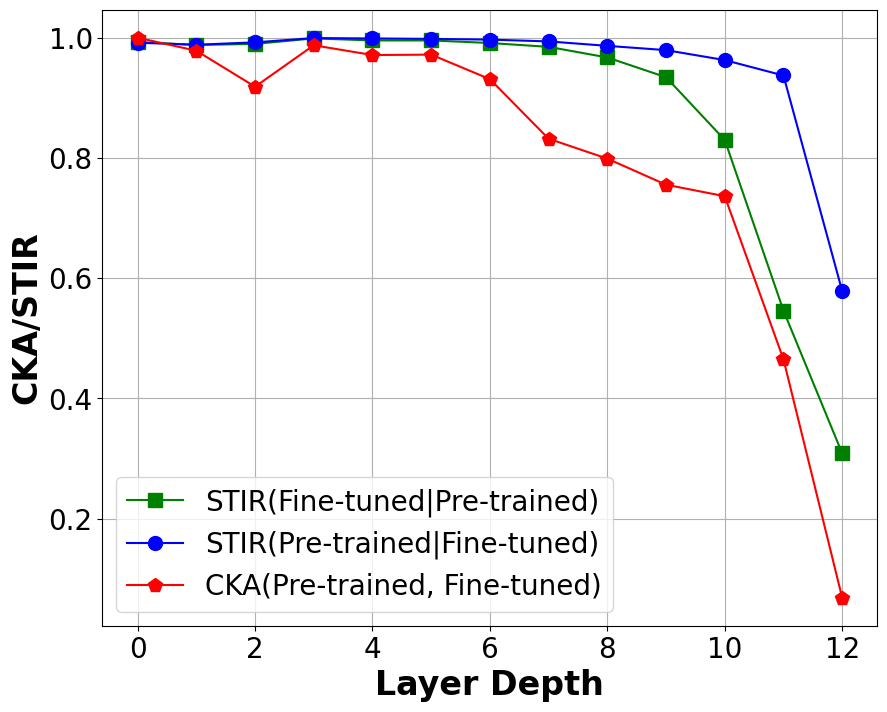

In [63]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(13)
plt.rcParams["figure.figsize"] = [10,8]

series = np.array(STIRm2m1)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='s', markersize=10, color='green')

series = np.array(STIRm1m2)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='o', markersize=10, color='blue')

series = np.array(CKA)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='p', markersize=10, color='red')

plt.legend(['STIR(Fine-tuned|Pre-trained)', 'STIR(Pre-trained|Fine-tuned)', 'CKA(Pre-trained, Fine-tuned)'], fontsize=20)
plt.xlabel('Layer Depth', fontsize = 24, fontweight = 'bold')
plt.ylabel('CKA/STIR', fontsize = 24, fontweight ='bold')

plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.tight_layout()
#plt.show()
plt.savefig('AX CKA STIR.pdf', bbox_inches='tight')
plt.savefig('AX CKA STIR.jpg', bbox_inches='tight')

In [15]:
class Dataset(Dataset):
    def __init__(self, premise, hypothesis):
        self.premise = premise
        self.hypothesis = hypothesis
  
    def __len__(self):
        return len(self.premise)

    def __getitem__(self, index):
        return {
            'premise': self.premise[index],
            'hypothesis':self.hypothesis[index],
            'label':0,
        }

testm_dataset = Dataset(testm_premise, testm_hypothesis)
testmm_dataset = Dataset(testmm_premise, testmm_hypothesis)
testax_dataset = Dataset(testax_premise, testax_hypothesis)

testm_dataloader = DataLoader(testm_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `testm_dataloader` with %d batches!'%len(testm_dataloader))

testmm_dataloader = DataLoader(testmm_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `testmm_dataloader` with %d batches!'%len(testmm_dataloader))

testax_dataloader = DataLoader(testax_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `testax_dataloader` with %d batches!'%len(testax_dataloader))

Created `testm_dataloader` with 613 batches!
Created `testmm_dataloader` with 616 batches!
Created `testax_dataloader` with 69 batches!


In [16]:
def test(dataloader, device_):
    predictions_labels = []
    model.eval()

    for batch in tqdm(dataloader, total=len(dataloader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        
        with torch.no_grad():        
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=True)
            logits = outputs.logits
            pred = torch.argmax(logits, dim = 1).tolist()
            predict_content = []
            for j in range(len(pred)):
                if pred[j]==0:
                    predict_content.append('entailment')
                elif(pred[j]==1):
                    predict_content.append('neutral')
                else:
                    predict_content.append('contradiction')
            predictions_labels.extend(predict_content)

    return predictions_labels

In [17]:
import pandas as pd
predictions = test(testm_dataloader, device)
filename = '../swapWords/MNLI-m.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

  0%|          | 0/613 [00:00<?, ?it/s]

In [18]:
import pandas as pd
predictions = test(testmm_dataloader, device)
filename = '../swapWords/MNLI-mm.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

  0%|          | 0/616 [00:00<?, ?it/s]

In [19]:
predictions = test(testax_dataloader, device)
filename = '../swapWords/AX.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

  0%|          | 0/69 [00:00<?, ?it/s]

In [8]:
ax_dataset = load_dataset('glue', 'ax')
testax_dataloader = DataLoader(ax_dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/ax/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/1 [00:00<?, ?it/s]

### Removing first word

In [ ]:
testm_premise = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test_matched']['premise']]
testm_hypothesis = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test_matched']['hypothesis']]
testmm_premise = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test_mismatched']['premise']]
testmm_hypothesis = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test_mismatched']['hypothesis']]
testax_premise = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in ax_dataset['test']['premise']]
testax_hypothesis = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in ax_dataset['test']['hypothesis']]

### Removing last word

In [ ]:
testm_premise = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test_matched']['premise']]
testm_hypothesis = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test_matched']['hypothesis']]
testmm_premise = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test_mismatched']['premise']]
testmm_hypothesis = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test_mismatched']['hypothesis']]
testax_premise = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in ax_dataset['test']['premise']]
testax_hypothesis = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in ax_dataset['test']['hypothesis']]

### Removing nouns

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

def remove_nouns(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = pos_tag(words)
    filtered_sentence = [word for word, pos in tagged_words if pos != 'NN' and pos != 'NNP' and pos != 'NNS']
    return ' '.join(filtered_sentence)

testm_premise = [remove_nouns(sentence) for sentence in dataset['test_matched']['premise']]
testmm_premise = [remove_nouns(sentence) for sentence in dataset['test_mismatched']['premise']]
textax_premise = [remove_nouns(sentence) for sentence in ax_dataset['test']['premise']]

testm_hypothesis = [remove_nouns(sentence) for sentence in dataset['test_matched']['hypothesis']]
testmm_hypothesis = [remove_nouns(sentence) for sentence in dataset['test_mismatched']['hypothesis']]
testax_hypothesis = [remove_nouns(sentence) for sentence in ax_dataset['test']['hypothesis']]

### Removing verbs

In [ ]:
def remove_verbs(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = pos_tag(words)
    filtered_sentence = [word for word, pos in tagged_words if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
    return ' '.join(filtered_sentence)

testm_premise = [remove_verbs(sentence) for sentence in dataset['test_matched']['premise']]
testmm_premise = [remove_verbs(sentence) for sentence in dataset['test_mismatched']['premise']]
textax_premise = [remove_verbs(sentence) for sentence in ax_dataset['test']['premise']]

testm_hypothesis = [remove_verbs(sentence) for sentence in dataset['test_matched']['hypothesis']]
testmm_hypothesis = [remove_verbs(sentence) for sentence in dataset['test_mismatched']['hypothesis']]
testax_hypothesis = [remove_verbs(sentence) for sentence in ax_dataset['test']['hypothesis']]

### Swap text

In [14]:
import nltk
import random
from nltk.tokenize import word_tokenize

def random_swap_words(sentence):
    words = word_tokenize(sentence)
    if len(words) >= 2:
        i, j = random.sample(range(len(words)), 2)
        words[i], words[j] = words[j], words[i]
        return " ".join(words)
    else:
        return sentence

testm_premise = [random_swap_words(sentence) for sentence in dataset['test_matched']['premise']]
testmm_premise = [random_swap_words(sentence) for sentence in dataset['test_mismatched']['premise']]
testax_premise = [random_swap_words(sentence) for sentence in ax_dataset['test']['premise']]

testm_hypothesis = [random_swap_words(sentence) for sentence in dataset['test_matched']['hypothesis']]
testmm_hypothesis = [random_swap_words(sentence) for sentence in dataset['test_mismatched']['hypothesis']]
testax_hypothesis = [random_swap_words(sentence) for sentence in ax_dataset['test']['hypothesis']]

### Add text

In [42]:
import random
from faker import Faker
from typing import List

def add_random_words(sentences: List[str]):
    fake = Faker()
    new_sentences = []
    for sentence in sentences:
        words = sentence.split()
        num_words_to_add = int(len(words) / 5)
        for i in range(num_words_to_add):
            insert_index = random.randint(0, len(words) - 1)
            words.insert(insert_index, fake.word())
        new_sentences.append(" ".join(words))
    return new_sentences

testm_premise = add_random_words(dataset['test_matched']['premise'])
testmm_premise = add_random_words(dataset['test_mismatched']['premise'])
textax_premise = add_random_words(ax_dataset['test']['premise'])

testm_hypothesis = add_random_words(dataset['test_matched']['hypothesis'])
testmm_hypothesis = add_random_words(dataset['test_mismatched']['hypothesis'])
testax_hypothesis = add_random_words(ax_dataset['test']['hypothesis'])

### Change char

In [ ]:
import random
import string

def replace_characters(sentence, probability=0.10):
    new_sentence = ""
    for char in sentence:
        if random.random() < probability:
            char = random.choice(string.ascii_letters)
        new_sentence += char
    return new_sentence

testm_premise = [replace_characters(sentence) for sentence in dataset['test_matched']['premise']]
testmm_premise = [replace_characters(sentence) for sentence in dataset['test_mismatched']['premise']]
textax_premise = [replace_characters(sentence) for sentence in ax_dataset['test']['premise']]

testm_hypothesis = [replace_characters(sentence) for sentence in dataset['test_matched']['hypothesis']]
testmm_hypothesis = [replace_characters(sentence) for sentence in dataset['test_mismatched']['hypothesis']]
testax_hypothesis = [replace_characters(sentence) for sentence in ax_dataset['test']['hypothesis']]

### Bias

In [45]:
def changeGender(str):
    dictionary = {
    "batman": "batwoman", "batwoman": "batman",
    "boy": "girl", "girl": "boy",
    "boyfriend": "girlfriend", "girlfriend": "boyfriend",
    "father": "mother", "mother": "father",
    "husband": "wife", "wife": "husband",
    "he": "she", "she": "he", "He":"She", "She":"He",
    "his": "her", "her": "his", "His":"Her", "Her":"His",
    "male": "female", "female": "male","him":"her","her":"him",
    "man": "woman", "woman": "man",
    "Mr": "Ms", "Mr": "Ms",
    "sir": "madam", "madam": "sir",
    "son": "daughter", "daughter": "son",
    "uncle": "aunt", "aunt": "uncle",
    }

    str = str + ' ' # Append a space at the en
    temp = ""
    ans = ""

    for i in range(len(str)):
        if str[i] != ' ':
            temp += str[i]
        else:
            if temp in dictionary:
                temp = dictionary[temp]

            ans = ans + temp + ' '
            temp = ""

    return ans

testm_premise = [changeGender(sentence) for sentence in dataset['test_matched']['premise']]
testmm_premise = [changeGender(sentence) for sentence in dataset['test_mismatched']['premise']]
textax_premise = [changeGender(sentence) for sentence in ax_dataset['test']['premise']]

testm_hypothesis = [changeGender(sentence) for sentence in dataset['test_matched']['hypothesis']]
testmm_hypothesis = [changeGender(sentence) for sentence in dataset['test_mismatched']['hypothesis']]
testax_hypothesis = [changeGender(sentence) for sentence in ax_dataset['test']['hypothesis']]